In [1]:
import os
import dotenv
import numpy as np
from dataclasses import replace
import matplotlib.pyplot as plt
from pulser import Pulse, Register, Sequence
from pulser.register.register_layout import RegisterLayout
from pulser.devices import Chadoq2
from pulser.channels.dmm import DMM
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform
from pasqal_cloud import SDK
from pasqal_cloud.device import EmulatorType

In [2]:
# %%
N = 8
L = 7.0
omega_max = 15

trap_coordinates = [(i*L, 0.0) for i in range(N)]
weights = np.ones((N))

register = Register.from_coordinates(trap_coordinates, center=False, prefix="q")

# %%
weights = np.array([0.325, 0] + list(np.linspace(0.5, 1, N-2)))
weights /= weights.sum()

register_layout = RegisterLayout(trap_coordinates)
detuning_map = register_layout.define_detuning_map(
    {i: weights[i] for i in range(N)}  # mapping between trap ids and weights
)

delta_abs = 8
T = 10000 # in ns, evolution time

#-------------DEFINE A VIRTUAL MACHINE TO REUSE LOCAL CHANNEL
VirtualChadoq2 = Chadoq2.to_virtual()
VirtualChadoq2 = replace(VirtualChadoq2, reusable_channels=True)
#----------------------------------------------------------#

seq = Sequence(register, VirtualChadoq2)

# global channel
seq.declare_channel("ch0", "rydberg_global")
adiabatic_pulse = Pulse(
    amplitude = InterpolatedWaveform(T, [1e-9, omega_max, 1e-9]),
    detuning = InterpolatedWaveform(T, [-delta_abs, delta_abs]),
    phase = 0
)
seq.add(adiabatic_pulse, "ch0")


#---------------------------DETUNING MAP WORKAROUND
# "dmm_" names are reserved so we cannot use them
seq.declare_channel("my_dmm_0","rydberg_local", initial_target="q0")
detuning_map = Pulse(
    amplitude = ConstantWaveform(T, 0.0),
    detuning = ConstantWaveform(T, -delta_abs / 2 / weights.max()),
    phase = 0
)
# no-delay protocol to allow addressing the same atom in different channels
seq.add(detuning_map, "my_dmm_0", protocol="no-delay")


# add a second local detuning
seq.declare_channel("my_dmm_1","rydberg_local", initial_target="q1")
seq.add(detuning_map, "my_dmm_1", protocol="no-delay")
#----------------------------------------------------------#

In [3]:
# %%
serialized_sequence = seq.to_abstract_repr()

# %%
dotenv.load_dotenv()
project_id = os.environ.get('PASQAL_PROJECT_ID')
username = os.environ.get('PASQAL_USERNAME')
password = os.environ.get('PASQAL_PASSWORD')

if not all([project_id, username, password]):
    raise ValueError("Missing PASQAL credentials. Please set environment variables.")

# %%
sdk = SDK(username=username, password=password, project_id=project_id)

job = {"runs": 50, "variables": {}}

batch = sdk.create_batch(
    serialized_sequence, [job], emulator=EmulatorType.EMU_TN
)

for job in batch.ordered_jobs:
    print(f"job-id: {job.id}, status: {job.status}, result: {job.result}")


job-id: 71c63ab6-baf9-41ad-a180-7485df2bad8e, status: PENDING, result: None
None


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
# you need to wait for the job to finish

{'00100101': 18, '00101001': 18, '00010101': 6, '00101010': 5, '00101000': 1, '00010001': 1, '00100001': 1}


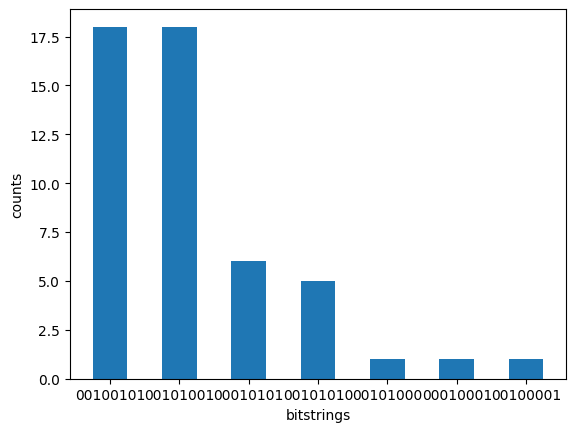

In [5]:
# %%
result = sdk.get_batch(batch.id)
print(result.ordered_jobs[0].result)
count_dict = result.ordered_jobs[0].result


# %%
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
plt.figure()
plt.xlabel("bitstrings")
plt.ylabel("counts")
plt.bar(count_dict.keys(), count_dict.values(), width=0.5)
plt.xticks(rotation="horizontal")
plt.show()